# Ejemplo de programación elementos finitos.
## Introducción.

El objetivo de esta práctica es ver una pequeña introducción a como preparar un programa de cálculo de elementos finitos.
Para ello partiremos de un ejemplo de un modelo de barras en dos dimensiones (celosías).
A partir del ejemplo se irán desarrollando paso a paso las distintas funciones necesarias para su solución.
La programación se realizará en python utilizando las siguientes librerías:

1. math
1. numpy
2. scipy
3. matplotlib

El código se implementará en un notebook de jupyter que permite la mezcla de texto, gráficos y código de forma sencilla mediante el uso de celdas de tipo *markdown* o tipo *code*.

Primeramente se cargan las librerías o módulos de python que se usarán en el cálculo.


In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt
import math

## Ejemplo

Vamos a utilizar el siguiente ejemplo como base para desarrollar las funciones que nos permitirán resolver el problema, pero que serán funciones genéricas aptas para otros problemas:

![esquema](esquema.png)

Como en el lenguaje python los arrays, listas, etc. se indexan empezando por cero, uilizaremos ese convenio en la descripción del modelo.
Los nodos se numerarán de forma correlativa empezando por cero, con los elementos se hará de forma similar y para establecer las fuerzas concentradas en nodos se usará el nodo, la dirección (0 para el eje x y 1 para el eje y) ysu valor. Las condiciones de contorno se definirán de forma similar a las fuerzas pero sin el dato valor.
Si resumimos la información del modelo relevante para el cálculo observamos lo siguiente:

* Coordenadas de los nodos.

| Nodo  |  x  |  y  |
| ---   | --- | --- |
| 0     |  0  |  0  |
| 1     |  2  |  0  |
| 2     |  1  |  2  |

*  Elementos (barras articuladas)

| Elemento  |  nodo 1  |  nodo  2  |   EA    |
| ---       | ---      | ---       | ---     |
|    0      |    0     |   1       |   1000  |
|    1      |    0     |   2        |  1000  |
|    2      |    1     |   2        |  1000  |

* fuerzas aplicadas

| Nodo  |  dirección  | valor |
| ---   | ---         | ---   |
| 2     |    0        | 1    |

* Condiciones de contorno

| Nodo  |  dirección  | 
| ---   | ---         | 
| 0     |    0        | 
| 0     |    1        | 
| 1     |    1        | 


Lo primero que se hará es definir formalmente el modelo en el lenguaje en cuestión. Para el caso que nos ocupa usaremos un array del tipo numpy para las coordenadas y listas para los elementos, las fuerzas y las condiciones de contorno.
Crearemos las variables correspondientes con los nombres que nos parezcan oportunos.

Para los nodos un array con sus coordenadas ``[[x0,y0],[x1,y1],...]``  
Para los elementos una lista con los mismos ``[el1,el2,....]``, donde cada elemento es ``[nodo 1, nodo 2, EA]``    
Para las fuerzas una lista con cada una de las componentes  ``[[nodo,dirección,F_val],...]``    
Y para las condiciones de contorno una lista similar  ``[[nodo,dirección],...]``  
Escribiéndolo en python tendríamos lo siguiente

In [2]:
x = np.array([[0,0],[2,0],[1,2]])
elementos = [[0,1,1000],[0,2,1000],[1,2,1000]]
fuerzas = [[2,0,1]]
cc = [[0,0],[0,1],[1,1]]

## Matriz de rigidez del modelo

El objetivo del cálculo es llegar a una ecuación del tipo $\mathbf{K}\mathbf{d}=\mathbf{f}$ donde $\mathbf{K}$ es la matriz de rigidez global del modelo que se obtiene a partir de las matrices de rigidez de cada elemento ensambladas (sumadas en una cierta posición dependiente de los nodos) en la global.

El vector de fuerzas $\mathbf{f}$ también se obtiene de forma similar ensamblando las fuerzas, dadas cada una de ellas en la posición correspondiente.

Como los grados de libertad considerados son dos por nodo (u según x,v según y), las dimensiones de las matrices serán, siendo $n$ el número de nodos.

|   Matriz    |  dimensión |
|  ----       |   -------  |
| $\mathbf{K}$ | $2n\times2n$ |
| $\mathbf{d}$ | $2n$        |
| $\mathbf{f}$ | $2n$      |

Al haber indexado a partir de cero la relación entre nodo, dirección y grado de libertad es muy sencilla:
Al nodo $i$, dirección $j$ le corresonde el grado de libertad (índice en las matrices)  $2i+j$


## Matriz de rigidez elemental

Primeramente obtendremos la función matriz de rigidez de un elemento.
Una vez obtenida se aplicará esa función a todos los elementos y se ensamblarán.

![elemento](elemento.png)

La matriz de rigidez del elemento es:

$ \mathbf{K}_{el} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs & -c^2 & -cs \\
cs  & s^2 & -cs & -s^2 \\
-c^2 & -cs & c^2 & cs \\
-cs &  -s^2 & cs & s^2
\end{pmatrix}
$
siendo $c$ el coseno del ángulo que forma la barra con la horizontal y $s$ el seno.

Como se puede observar, en este caso, está formada por un bloque de $2\times2$ que se repite cuatro veces, dos de ellas con el signo cambiado.

Si denominamos al bloque básico $\mathbf{K}_{11}$ tendríamos lo siguiente
$ \mathbf{K_{11}} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs \\
cs & s^2 
\end{pmatrix}
$

y por tanto:
$ \mathbf{K_{el}} = 
\begin{pmatrix}
\mathbf{K}_{11} & -\mathbf{K}_{11} \\
-\mathbf{K}_{11}& \mathbf{K}_{11} 
\end{pmatrix}
$

Vamos a proceder paso a paso escribiendo funciones para obtener la matriz de rigidez elemental. Partimos de un elemento que está definido por: ``[nodo 1,nodo 2, EA]``.    
Además necesitaremos las coordenadas de los nodos (en concreto las diferencias) para obtener la longitud y los senos y los cosenos.


La primera función que vamos incluir es la que accede a las coordenadas de los nodos.  
Argumentos:
1. elemento,coordenadas  
   `[nodo 1,nodo 2, EA]`, coordenadas   
Resultado:
1. elemento modificado  
   ``[nodo 1, nodo 2, EA,x2-x1,y2-y1]``


In [3]:
fk_0 = lambda el,coor: [el[0],el[1],el[2],coor[el[1]][0]-coor[el[0]][0],coor[el[1]][1]-coor[el[0]][1]]

Para aplicar la función al elemento número 1 (elementos[1]) se haría del siguiente modo:

In [4]:
fk_0(elementos[1],x)

[0, 2, 1000, 1, 2]

La siguiente función calcula la longitud del elemento  
Argumentos:  
1. elemento  
   `[nodo 1,nodo 2, EA,x2-x1,y2-y1]`  
Resultado:  
1. elemento modificado  
   `[nodo 1, nodo 2, EA,l,x2-x1,y2-y1]`  

In [5]:
fk_1 = lambda el: [el[0],el[1],el[2],math.hypot(el[3],el[4]),el[3],el[4]]

Vemos como se aplicaría al elemento cero. Primeramente se aplicaría `fk_0`y posteriormente `fk_1`.

In [6]:
fk_1(fk_0(elementos[0],x))

[0, 1, 1000, 2.0, 2, 0]

Una vez que tenemos la longitud y las diferencias de coordenadas se puede obtener  el coseno, el seno y la rigidez axial $\frac{EA}{l}$  del elemento donde tanto el coseno como el seno se obtienen a partir de las diferencias de coordenadas y de la longitud.  
Se hace mediante una nueva función `fk_2` 


In [7]:
fk_2 = lambda el: [el[0],el[1],el[2]/el[3],el[4]/el[3],el[5]/el[3]]

Obsérvese que cada función parte de los resultados de la función anterior.

In [8]:
fk_2(fk_1(fk_0(elementos[0],x)))

[0, 1, 500.0, 1.0, 0.0]

Ahora se puede obtener el bloque elemental $\mathbf{K}_{11}$ de la matriz de rigidez elemental  
$ \mathbf{K_{11}} = 
\frac{EA}{l}\begin{pmatrix}
c^2 & cs \\
cs & s^2 
\end{pmatrix}
$

In [9]:
fk_11 = lambda el: el[2]*np.array([[el[3]**2,el[3]*el[4]],[el[3]*el[4],el[4]**2]])

El bloque elemental es un array del tipo numpy.

In [10]:
fk_11(fk_2(fk_1(fk_0(elementos[0],x))))

array([[500.,   0.],
       [  0.,   0.]])

***
Y a partir del bloque $\mathbf{K}_{11}$ podemos obtener la matriz de rigidez local del elemento  
$ \mathbf{K_{el}} = 
\begin{pmatrix}
\mathbf{K}_{11} & -\mathbf{K}_{11} \\
-\mathbf{K}_{11}& \mathbf{K}_{11} 
\end{pmatrix}
$

In [11]:
fk_loc = lambda k11: np.vstack((np.hstack((k11,-k11)),np.hstack((-k11,k11))))

In [12]:
fk_loc(fk_11(fk_2(fk_1(fk_0(elementos[0],x)))))

array([[ 500.,    0., -500.,   -0.],
       [   0.,    0.,   -0.,   -0.],
       [-500.,   -0.,  500.,    0.],
       [  -0.,   -0.,    0.,    0.]])

Todas las funciones auxiliares para obtener la matriz de rigidez las podemos juntar en una sola que a partir de los datos de un elemento y del array de coordenadas del modelo devuelve la matriz de rigidez del elemento.

In [13]:
fk_el = lambda elemento,coor: fk_loc(fk_11(fk_2(fk_1(fk_0(elemento,coor)))))

In [14]:
fk_el(elementos[2],x)

array([[  89.4427191, -178.8854382,  -89.4427191,  178.8854382],
       [-178.8854382,  357.7708764,  178.8854382, -357.7708764],
       [ -89.4427191,  178.8854382,   89.4427191, -178.8854382],
       [ 178.8854382, -357.7708764, -178.8854382,  357.7708764]])

## Matriz de rigidez de un conjunto de elementos y ensamblaje

Una vez que tengo una función para obtener la matriz de rigidez de un elemento, la forma de obtener las matrices de rigidez de todos los elementos es aplicar esa función a todos los elementos.

In [15]:
fk_els = lambda elementos,coor: list(map(lambda elemento: fk_el(elemento,coor),elementos))

In [16]:
fk_els(elementos,x)

[array([[ 500.,    0., -500.,   -0.],
        [   0.,    0.,   -0.,   -0.],
        [-500.,   -0.,  500.,    0.],
        [  -0.,   -0.,    0.,    0.]]),
 array([[  89.4427191,  178.8854382,  -89.4427191, -178.8854382],
        [ 178.8854382,  357.7708764, -178.8854382, -357.7708764],
        [ -89.4427191, -178.8854382,   89.4427191,  178.8854382],
        [-178.8854382, -357.7708764,  178.8854382,  357.7708764]]),
 array([[  89.4427191, -178.8854382,  -89.4427191,  178.8854382],
        [-178.8854382,  357.7708764,  178.8854382, -357.7708764],
        [ -89.4427191,  178.8854382,   89.4427191, -178.8854382],
        [ 178.8854382, -357.7708764, -178.8854382,  357.7708764]])]

Con vistas al ensamblaje nos conviene tener todos los elementos de las matrices de rigidez en un array unidimensional. Para ello usaremos la función np.ravel y definimos una nueva función.  
Esta función simplemeente calcula todas las matrices de rigidez de todos los elementos y las devuelve en un array de una dimensión.

In [17]:
f_kg1 = lambda elementos,coordenadas:np.ravel(fk_els(elementos,coordenadas))

In [18]:
f_kg1(elementos,x)

array([ 500.       ,    0.       , -500.       ,   -0.       ,
          0.       ,    0.       ,   -0.       ,   -0.       ,
       -500.       ,   -0.       ,  500.       ,    0.       ,
         -0.       ,   -0.       ,    0.       ,    0.       ,
         89.4427191,  178.8854382,  -89.4427191, -178.8854382,
        178.8854382,  357.7708764, -178.8854382, -357.7708764,
        -89.4427191, -178.8854382,   89.4427191,  178.8854382,
       -178.8854382, -357.7708764,  178.8854382,  357.7708764,
         89.4427191, -178.8854382,  -89.4427191,  178.8854382,
       -178.8854382,  357.7708764,  178.8854382, -357.7708764,
        -89.4427191,  178.8854382,   89.4427191, -178.8854382,
        178.8854382, -357.7708764, -178.8854382,  357.7708764])

Para poder enamblar las matrices de rigidez es necesario saber a que índices de la matriz de rigidez global va cada elemento de una matriz de rigidez elemental.
Vamos a crear unas funciones que nos den esos índices en función de los nodos del elemento, una función para las filas de todos los elementos de la matriz y otra función para las columnas.


In [19]:
columnask = lambda y:  np.array(list(( map(lambda x: [x*2,x*2+1],y)))*4).flatten()
filask = lambda y:  np.array(list(( map(lambda x: [list([x*2])*4,list([x*2+1])*4],y)))).flatten()

Si se desea saber a que filas de la matriz de rigidez global van los elementos de la matriz de rigidez del elemento que une los nodos $0$ y $1$ usaríamos la función filask((0,1)).  
Del mismo modo para las columnas de la matriz de rigidez del elemento que va del nodo $1$ al nodo $2$ las columnas serían columnask((1,2)).

In [20]:
print(filask((1,2)))
print(columnask((1,2)))

[2 2 2 2 3 3 3 3 4 4 4 4 5 5 5 5]
[2 3 4 5 2 3 4 5 2 3 4 5 2 3 4 5]


Si se aplican las funciones a un conjunto de elementos se definen las siguientes funciones

In [21]:
fco = lambda elementos: list(np.ravel(list(map(lambda u: columnask((u[0],u[1])),elementos))))
ffi = lambda elementos: list(np.ravel(list(map(lambda u: filask((u[0],u[1])),elementos))))

Como ejemplo para obtener las columnas de todos los elementos de todas las matrices de rigidez se ejecutaría `fco(elementos)`

In [22]:
print(fco(elementos))

[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 4, 5, 0, 1, 4, 5, 0, 1, 4, 5, 0, 1, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5, 2, 3, 4, 5]


Una vez que se dispone de las matrices de rigidez de todos los elementos y las filas y columnas de cada elemento de cada matriz se pueden ensamblar en la matriz de rigidez global.
Utilizaremos el formato de matriz sparse (`sp.csr_matrix`) del módulo de python `scipy` que a la vez que genera la matriz sparse va sumando los distintos elementos.


In [23]:
f_kg = lambda elems,x: sp.csr_matrix(sp.coo_matrix((f_kg1(elems,x),(fco(elems),ffi(elems))),shape=(len(x)*2,len(x)*2)))


La matriz obtenida es de tipo *sparse*. Para poder escribirla en el formato convencional se convierte a densa.

In [24]:
print(f_kg(elementos,x).todense())

[[ 589.4427191  178.8854382 -500.           0.         -89.4427191
  -178.8854382]
 [ 178.8854382  357.7708764    0.           0.        -178.8854382
  -357.7708764]
 [-500.           0.         589.4427191 -178.8854382  -89.4427191
   178.8854382]
 [   0.           0.        -178.8854382  357.7708764  178.8854382
  -357.7708764]
 [ -89.4427191 -178.8854382  -89.4427191  178.8854382  178.8854382
     0.       ]
 [-178.8854382 -357.7708764  178.8854382 -357.7708764    0.
   715.5417528]]


## Condiciones de contorno

La matriz obtenida es singular dado que no hemos incluido ninguna condición de contorno, como se puede comprobar obteniendo el determinante.

In [25]:
np.linalg.det(f_kg(elementos,x).todense())


0.0

Las condiciones de contorno podrían incluirse eliminando las filas y columnas de la matriz de rigidez correspondientes a los grados de libertad restringidos, pero una forma más simple es imponiendo las restricciones por penalización. Se añaden en los elementos de  la diagonal de la matriz de rigidez correspondientes a los grados de libertad restringidos unos valores de rigidez muy elevados que imponen de forma aproximada el cumplimiento de la restricción.  
De este modo se mantienen las dimensiones de las matrices que en el otro caso habrían cambiado.

Si denominamos al valor elevado de rigidez $kpen$ y tenemos en el nodo $i$ restringido el grado de libertad $j$ basta con añadir el valor $kpen$ al elemento de la matriz de rigidez global $\left(2i+j,2i+j\right)$  

Para poder incluir estas condiciones de contorno de forma sencilla se prepara una función `f_kgp` que utiliza la matriz de rigidez global y añade los elementos correspondientes (`f_cc1` devuelve el valor de los elementos y `f_cc2` los índices fila y columna en la matriz de rigidez global) en el sitio adecuado.


In [26]:
kpen = 1e20
f_cc1 = lambda cc: list(map(lambda u: kpen,cc))
f_cc2 = lambda cc: list(map(lambda u: u[0]*2+u[1],cc))
f_kgp = lambda elems,x,cc: sp.csr_matrix(sp.coo_matrix((np.hstack((f_kg1(elems,x),f_cc1(cc))),(fco(elems)+f_cc2(cc),ffi(elems)+f_cc2(cc))),shape=(len(x)*2,len(x)*2)))

Como se puede comprobar, ahora la matriz de rigidez modificada ya no es singular.

In [27]:
np.linalg.det(f_kgp(elementos,x,cc).todense())


6.400000000000038e+67

## Fuerzas

El vector de fuerzas se obtiene de forma similar a la matriz de rigidez. Se crea una matriz sparse con una sola columna a partir de los valores de las fuerzas aplicadas y de los grados de libertad correspondientes.  
Para ello usaremos dos funciones auxiliares.  
1. `f_b1` transforma la lista de fuerzas en una lista con los valores de las fuerzas y las filas del vector global f (además de un 0 para la columna)
2. `f_b` ensambla el vector de fuerzas en una matriz sparse de forma similar a `f_kg1`


In [28]:
f_b1 = lambda fuerzas: (list(map(lambda u: u[2],fuerzas)),(list(map(lambda u: u[0]*2+u[1],fuerzas)),list(map(lambda u: 0,fuerzas))))
f_b = lambda fuerzas,x: sp.csr_matrix(sp.coo_matrix((f_b1(fuerzas)),shape=(len(x)*2,1)))

In [29]:
print(f_b(fuerzas,x))

  (4, 0)	1


Hemos obtenido una matriz sparse de $6\times1$ con un elemento no nulo de valor $1$ en el índice 4 que se corresponde con el nodo $2$ y dirección $x$

Una vez que tenemos la matriz de rigidez global y el vector de fuerzas global podemos resolver el sistema de ecuaciones 

In [30]:
d = spsolve(f_kgp(elementos,x,cc),f_b(fuerzas,x)).reshape(3,2)
print(d)

[[ 1.00000000e-20  1.00000000e-20]
 [ 1.00000000e-03 -1.00000000e-20]
 [ 6.09016994e-03 -2.50000000e-04]]


Podemos crear una función para resolver el problema

In [31]:
f_solve = lambda x,els,fuerzas,cc: spsolve(f_kgp(els,x,cc),f_b(fuerzas,x)).reshape(len(x),2)

In [32]:
d = f_solve(x,elementos,fuerzas,cc)
print(d)

[[ 1.00000000e-20  1.00000000e-20]
 [ 1.00000000e-03 -1.00000000e-20]
 [ 6.09016994e-03 -2.50000000e-04]]


Utilizaremos las siguientes funciones para dibujar los nodos o los elementos y que tienen como argumentos las coordenadas de los nodos, para el caso de los nodos y las coordenadas y los elementos para la de los elementos.
Aparte tienen un argumento opcional para indicar el símbolo y/o color a usar.

In [33]:
f_dibnodos= lambda x,color='go': plt.plot(x[:,0],x[:,1],color)
f_dibelems = lambda x,elems,color='r':plt.plot(*(sum(list(map(lambda u: [(x[u[0]][0],x[u[1]][0]),(x[u[0]][1],x[u[1]][1]),color],elems)),[] )))

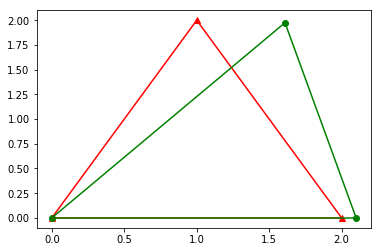

In [34]:
f_dibnodos(x,'r^')
f_dibnodos(x+100*d,'go')
f_dibelems(x,elementos,'r')
f_dibelems(x+100*d,elementos,'g')

Para obtener los esfuerzos en las barras hay que obtener el movimiento axial y multiplicarlo por la rigidez de la barra. Utilizaremos primeramente la función `f_Ne` que devuelve el axil de un elemento dado, utilizando como argumentos el elemento, las coordenadas de los nodos y los movimientos de los nodos.  
Posteriormente para obtener los axiles de todos los elementos tenemos la función `f_N` que aplica `f_Ne` a todos los elementos.

In [35]:
f_N1 = lambda elemento,x: fk_1(fk_0(elemento,x))
f_Ne = lambda elemento,x,u: (elemento[2]/(fk_1(fk_0(elemento,x))[3])**2)*(np.dot(f_N1(elemento,x)[-2:],f_N1(elemento,u)[-2:]))
f_N = lambda elementos,x,u: list(map(lambda v: f_Ne(v,x,u),elementos))

Axil del elemento 1

In [36]:
f_Ne(elementos[1],x,d)

1.1180339887498947

Obtención de todos los axiles

In [37]:
f_N(elementos,x,d)

[0.5, 1.1180339887498947, -1.118033988749895]

## Movimientos impuestos
Si tenemos algún movimiento impuesto en el modelo se puede imponer mediante penalización.
Se impone una restricción en el grado de libertad correspondiente y se aplica una fuerza en ese mismo grado de libertad de valor el movimiento impuesto multiplicado por la constante de penalización.  
Veamos el ejemplo anterior donde en vez de aplicar una fuerza se desea que el nodo $2$ se mueva $-0.2$ en direción $x$  
Añadiríamos una nueva condición de contorno y aplicaríamos la fuerza correspondiente.

In [38]:
cc2 = cc+[[2,0]]
fuerzas2 = [[2,0,-kpen*0.2]]

Resolvemos y obtenemos el resultado previsto.

In [39]:
d2 = f_solve(x,elementos,fuerzas2,cc2)
print(d2)

[[-3.28398061e-19 -3.28398061e-19]
 [-3.28398061e-02  3.28398061e-19]
 [-2.00000000e-01  8.20995152e-03]]


que se puede dibujar utlizando los movimientos a escala 1:1

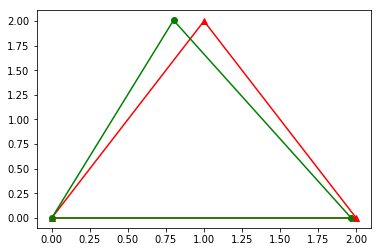

In [40]:
f_dibnodos(x,'r^')
f_dibnodos(x+d2,'go')
f_dibelems(x,elementos,'r')
f_dibelems(x+d2,elementos,'g')

## Generación de nodos
Con el fin facilitar la generación de los datos de los modelos vamos a incluir unas funciones para la generación de coordenadas y nodos.
La función que usaremos es gennodos.
Tiene los siguientes argumentos:

1. xf. Función de las variables (u,v)
2. yf. Función de las variables (u,v)
3. ues. Rango de los valores de u en la forma [u0,uf,nu]
3. ves. Rango de los valores de v en la forma [v0,vf,nv]
3. patterns. Esquema de numeración de los nodos.
3. n0. Número del primer nodo generado.
4. ntot. Número total de nodos del modelo.

y devuelve el array de coordenadas de los nodos.  
Las funciones `xf(u,v)->u`   y `yf(u,v)->v` están ya predefinidas.

El único argumento que hay que explicar es `patterns` que establece como se van asignando números de nodos a las coordenadas que se van generando.
Se generan $nu\times{}nv$ coordenadas que se obtienen evaluando las funciones `xf` e `yf` sobre el producto cartesiano de los `nu` valores generados entre `u0` y `uf` por los `nv` valores generados entre `v0` y `vf`.  
La forma de asignar los nodos es utilizando la lista patterns `[[d1,s1],[d2,s2],...]`  
Se van asignando nodos a las coordenadas empezando por `n0`, a cada incremento de `s1` de las coordenadas (las $nu\times{}nv$ coordenadas) se incrementa `d1` el índice del nodo. Se hace lo mismo con cada par de valores `[d,s]` de la lista patterns.

In [41]:
xf = lambda u,v: u
yf = lambda u,v: v
f1  =lambda u: np.linspace(u[0],u[1],u[2])
f2 = lambda u,v : np.meshgrid(f1(u),f1(v))
f3 = lambda xu,u,v: xu(*f2(u,v)).reshape(u[2]*v[2],1)
f4 = lambda xu,yu,u,v : np.hstack((f3(xu,u,v),f3(yu,u,v)))
faux = lambda patterns,ntot: map(lambda x: [x[0],x[1],ntot],patterns)
fn1 = lambda d1,s1,n : (np.cumsum((np.ones(int(n/s1)))).reshape((int(n/s1),1))*d1-d1 + np.zeros(s1)).reshape(1,n)
fn2 = lambda d1,s1,n: fn1(d1,s1,(int((n-1)/s1)+1)*s1)[0][0:n].reshape(1,n)
fnumer = lambda ues,ves,patterns,n0: np.sum(list(map(lambda u: fn2(*u),faux(patterns,ues[2]*ves[2]))),dtype=int,axis=0)+n0 
nauxf = lambda nnodos: np.hstack((np.ones((1,nnodos),dtype=int)*0,np.ones((1,nnodos),dtype=int))).reshape(nnodos*2)
ensambf = lambda puntos,nodos,ntot: sp.coo_matrix((np.hstack((puntos[:,0],puntos[:,1])), (np.hstack((nodos,nodos)).reshape(nodos.size*2), nauxf(nodos.size))),shape=(ntot,2)).toarray()
gennodos=lambda xf,yf,ues,ves,patterns,n0,ntot:ensambf(f4(xf,yf,ues,ves),fnumer(ues,ves,patterns,n0),ntot)


Si queremos generar 6 nodos separados 1 en el eje $x$ a partir del origen.

In [42]:
xl1 = gennodos(xf,yf,[0,5,6],[0,0,1],[[1,1]],0,6)

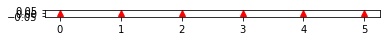

In [43]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl1,'r^')

Si queremos generar una malla de nodos en un rectángulo de lados 4x2 y queremos 6 nodos en el lado sobre el eje $x$ y $3$ sobre el eje $y$, con la numeración empezando por cero y creciendo según el eje $x$

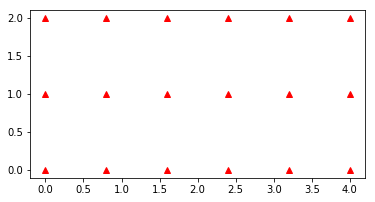

In [44]:
xl2 = gennodos(xf,yf,[0,4,6],[0,2,3],[[1,1]],0,18)
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl2,'r^')

In [45]:
print(xl2)

[[0.  0. ]
 [0.8 0. ]
 [1.6 0. ]
 [2.4 0. ]
 [3.2 0. ]
 [4.  0. ]
 [0.  1. ]
 [0.8 1. ]
 [1.6 1. ]
 [2.4 1. ]
 [3.2 1. ]
 [4.  1. ]
 [0.  2. ]
 [0.8 2. ]
 [1.6 2. ]
 [2.4 2. ]
 [3.2 2. ]
 [4.  2. ]]


Si queremos una malla de nodos sobre un cuarto de un sector circular entre los radios 3 y 5 con 8 nodos en la dirección del radio y 20 nodos circunferencialmente.

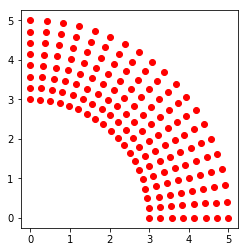

In [46]:
xf3 = lambda u,v: u*np.cos(v)
yf3 = lambda u,v: u*np.sin(v)
xl3 = gennodos(xf3,yf3,[3,5,8],[0,np.pi/2,20],[[1,1]],0,160)
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(xl3,'ro')


## Generación de elementos
Para la generación de elementos se seguirá un esquema similar al de la generación de nodos salvo que cada elemento tiene varios nodos sobre los que se aplicará el mismo esquema. De hecho usaremos la función `fnumer` de la generación de nodos.
Utilizaremos la función genelem que tiene los siguientes argumentos:  
1. `patterns` funciona de forma similar a la generación de nodos y tendrá un valor del tipo  `[[d11,d12,s1],[d21,d22,s2]...]`
2. `elbase`. Son los nodos del primer elemento.
3. `nelem`. Número de elementos a generar.
4. `x`. Coordenadas del modelo.
5. `eaf`. Una función dependiente de (x,y) que evaluada en el punto medio de cada barra nos devuelve el valor de $EA$, siendo $E$ el módulo de Young y $A$ la sección de la barra.

La función `fc` predefinida es la función  que con un argumento constante genera la función constante.

In [47]:
fc = lambda f: lambda x,y: f
fpat3 = lambda pat,elbase,nelem: list(map(lambda i: [[0,1,nelem],[0,1,1]]+[list(map(lambda x: [x[i],x[-1]],pat))]+[elbase[i]],np.arange(len(elbase))))
genelem0 = lambda patterns,elbase,nelem: np.hstack(list(map(lambda x: fnumer(*x).reshape(nelem,1),fpat3(patterns,elbase,nelem)))).tolist()
genelem1 = lambda elementos,x,eaf:list(map(lambda u: [u[0],u[1],eaf(0.5*(x[u[0]][0]+x[u[1]][0]),0.5*(x[u[0]][1]+x[u[1]][1]))],elementos))
genelem = lambda patterns,elbase,nelem,x,eaf:genelem1(genelem0(patterns,elbase,nelem),x,eaf)


## Generacion de fuerzas nodales con una funcion de (x,y) evaluada en el nodo
Se generan de forma similar a los elementos.

In [48]:
genfuerzas0 = lambda patterns,elbase,nelem: np.hstack(list(map(lambda x: fnumer(*x).reshape(nelem,1),fpat3(patterns,elbase,nelem)))).tolist()
genfuerzas1 = lambda elementos,x,ffuer:list(map(lambda u: [u[0],u[1],ffuer(x[u[0]][0],x[u[0]][1])],elementos))
genfuerzas = lambda patterns,elbase,nelem,x,eaf:genfuerzas1(genfuerzas0(patterns,elbase,nelem),x,eaf)

### Ejemplos de generación de elementos.

Generación de elementos en una dimensión correspondiente a los nodos xl1 generados anteriormente.

In [49]:
genelem([[1,1,1]],[0,1],4,xl1,fc(1000))

[[0, 1, 1000], [1, 2, 1000], [2, 3, 1000], [3, 4, 1000]]

# Solución del problema de abaqus 1d

A continuación se va a resolver con python el problema 1d resuelto con abaqus.  
La generación de nodos y de elementos es trivial.

In [50]:
x = gennodos(xf,yf,[0,10,11],[0,0,1],[[1,1]],0,11)

In [51]:
elems = genelem([[1,1,1]],[0,1],10,x,fc(1000))

Las condiciones de contorno se pueden generar con una de las funciones auxiliares de generar elementos.  
Hay que tener en cuenta que como el problema va a ser unidimensional se deben restringir los movimientos en la otra dirección.  
Es lo que haremos con las condiciones `cc1`

In [52]:
cc1 = genelem0([[1,0,1]],[0,1],11)

In [53]:
cc1

[[0, 1],
 [1, 1],
 [2, 1],
 [3, 1],
 [4, 1],
 [5, 1],
 [6, 1],
 [7, 1],
 [8, 1],
 [9, 1],
 [10, 1]]

Y se añade la condición de contorno que falta de movimiento coaccionado en x en el nodo 0.

In [54]:
cc = cc1 + [[0,0]]

Para la inclusión de la carga volumétrica se preparan unas funciones auxiliares para poder generar las cargas nodales equivalentes. `fq1` calula las fuerzas nodales equivalentes en los nodos iniciales de cada barra y `fq2` las de los  nodos finales.

In [55]:
fq = lambda x,y: 0.2+0.04*x
fq1 = lambda x,y: 1/6*(2*fq(x,0)+fq(x+1,0))
fq2 = lambda x,y: 1/6*(fq(x-1,0)+2*fq(x,0))

In [56]:
fuerz1 = genfuerzas([[1,0,1]],[0,0],10,x,fq1)
fuerz2 = genfuerzas([[1,0,1]],[1,0],10,x,fq2)

Añado la fuerza nodal del extremo libre.

In [57]:
fuerzas = fuerz1+fuerz2+[[10,0,5]]

In [58]:
fuerzas

[[0, 0, 0.10666666666666666],
 [1, 0, 0.12666666666666665],
 [2, 0, 0.14666666666666667],
 [3, 0, 0.16666666666666666],
 [4, 0, 0.18666666666666668],
 [5, 0, 0.20666666666666667],
 [6, 0, 0.22666666666666668],
 [7, 0, 0.24666666666666665],
 [8, 0, 0.26666666666666666],
 [9, 0, 0.2866666666666667],
 [1, 0, 0.11333333333333334],
 [2, 0, 0.13333333333333333],
 [3, 0, 0.15333333333333332],
 [4, 0, 0.17333333333333334],
 [5, 0, 0.19333333333333336],
 [6, 0, 0.21333333333333332],
 [7, 0, 0.23333333333333334],
 [8, 0, 0.2533333333333333],
 [9, 0, 0.2733333333333333],
 [10, 0, 0.29333333333333333],
 [10, 0, 5]]

In [59]:
u = f_solve(x,elems,fuerzas,cc)
print(u)

[[9.00000000e-20 0.00000000e+00]
 [8.89333333e-03 0.00000000e+00]
 [1.75466667e-02 0.00000000e+00]
 [2.59200000e-02 0.00000000e+00]
 [3.39733333e-02 0.00000000e+00]
 [4.16666667e-02 0.00000000e+00]
 [4.89600000e-02 0.00000000e+00]
 [5.58133333e-02 0.00000000e+00]
 [6.21866667e-02 0.00000000e+00]
 [6.80400000e-02 0.00000000e+00]
 [7.33333333e-02 0.00000000e+00]]


Leemos los resultados de abaqus que estarán preparados en un fichero con dos columnas de números separados por comas. Utilizaremos el módulo pandas para la lectura.

In [60]:
import pandas as pd
data = pd.read_csv('u3.txt', header = None)
u3_abaqus = data.to_numpy()

Y podemos representar la comparación entre los resultados de abaqus (los puntos del dibujo) y los calculados directamente.

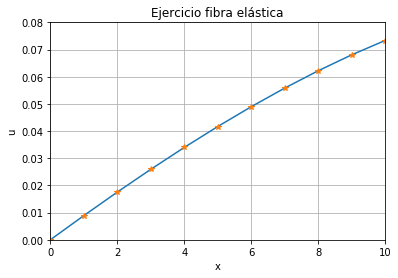

In [61]:
plt.xlabel('x')
plt.ylabel('u')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 0, 0.08])
plt.grid(True)
plt.plot(x[:,0],u[:,0],x[:,0],u3_abaqus[:,1],'*')

Se puede hacer lo mismo entre los axiles y la tensión `S33` obtenida en **abaqus** dado que al ser la sección de $1\times1$ coinciden numéricamente. Las tensiones se representarán en el punto geométrico en el que han sido obtenidas, es decir, el punto de Gauss del elemento.

In [62]:
axiles = f_N(elems,x,u)

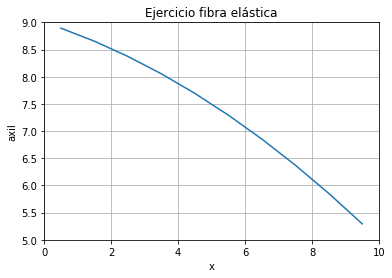

In [63]:
plt.xlabel('x')
plt.ylabel('axil')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 5, 9])
plt.grid(True)
plt.plot(np.linspace(0.5,9.5,10),axiles[:])

Lectura de las tensiones.

In [64]:
import pandas as pd
data = pd.read_csv('s33.rpt', header = None)
s33_abaqus = data.to_numpy()

Al comprobar que están ordenadas al revés invertiremos la lista de valores mediante `np.flip`

In [65]:
s33_abaqus[:,2]

array([5.29, 5.85, 6.37, 6.85, 7.29, 7.69, 8.05, 8.37, 8.65, 8.89])

In [66]:
s33_ab = np.flip(s33_abaqus[:,2])

Y por último obtenemos la representación de la comparación entre los dos resultados (`S33` de **abaqus** y axil del cálculo en python).

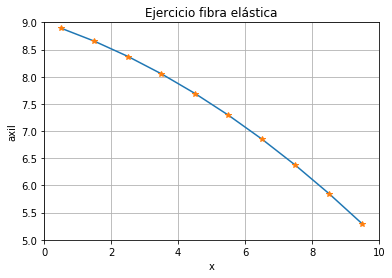

In [67]:
plt.xlabel('x')
plt.ylabel('axil')
plt.title('Ejercicio fibra elástica')
plt.axis([0, 10, 5, 9])
plt.grid(True)
plt.plot(np.linspace(0.5,9.5,10),axiles[:],np.linspace(0.5,9.5,10),s33_ab,'*')

# Ejemplos

A continuación se resolverán algunos ejemplos donde se vea también el uso de las funciones generadoras de nodos, elementos, etc...

## Viga recta de celosía.

El esquema que usaremos es el siguiente:

![celosia](celosia.png)

In [68]:
nx = 15
x = gennodos(xf,yf,[0,nx*8,nx+1],[0,2,2],[[1,1]],0,2*nx+2)

In [69]:
els1 = genelem([[1,1,1],[1,1,nx]],[0,1],2*nx,x,fc(1e6))

In [70]:
els2 = genelem([[1,1,1]],[0,nx+1],nx+1,x,fc(1e6))

In [71]:
els3 = genelem([[1,1,1]],[0,nx+2],nx,x,fc(1e6))
els4 = genelem([[1,1,1]],[1,nx+1],nx,x,fc(1e6))

In [72]:
elementos = els1+els2+els3+els4

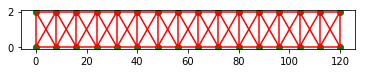

In [73]:
ax = plt.gca()
#ax.set_aspect('equal')
ax.set_aspect(7)
f_dibnodos(x);
f_dibelems(x,elementos);

Las condiciones de contorno son:  nodo inferior izquierdo fijo y nodo inferior derecho con un carrito.  
Las fuerzas son unas fuerzas concentradas en los nodos del cordón superior.

In [74]:
cc = [[0,0],[0,1],[nx,1]]
fuerzas = genfuerzas([[1,0,1]],[nx+1,1],nx+1,x,fc(10))

In [75]:
fuerzas

[[16, 1, 10],
 [17, 1, 10],
 [18, 1, 10],
 [19, 1, 10],
 [20, 1, 10],
 [21, 1, 10],
 [22, 1, 10],
 [23, 1, 10],
 [24, 1, 10],
 [25, 1, 10],
 [26, 1, 10],
 [27, 1, 10],
 [28, 1, 10],
 [29, 1, 10],
 [30, 1, 10],
 [31, 1, 10]]

Una vez que están creadas todas las variables que definen el modelo se resuelve.

In [76]:
u=f_solve(x,elementos,fuerzas,cc)

Dibujo de los movimientos de la viga.

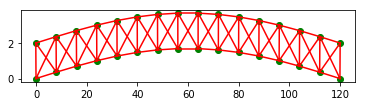

In [77]:
ax = plt.gca()
#ax.set_aspect('equal')
ax.set_aspect(7)
f_dibnodos(x+u);
f_dibelems(x+u,elementos);

In [78]:
plt.show()

## Arco parabólico de celosía

Podemos generar el modelo con forma de arco parabólico. Basta con utilizar las ecuaciones de la parábola.  
En este caso para una luz de 120 metros y una flecha de 30 metros.  
Se ha considerado que el canto de la viga se genera según la normal a la parábola.

In [79]:
nx = 15
xf2 = lambda u,v: u+v*(2/120*u)/np.sqrt(1+4*(1/120)*(1/120)*u*u)
yf2 = lambda u,v: -1/120*u*u+v*1/np.sqrt(1+(4/120)*(1/120)*u*u)
x = gennodos(xf2,yf2,[-nx*4,nx*4,nx+1],[0,4,2],[[1,1]],0,2*nx+2)

Dibujamos los nodos solamente.

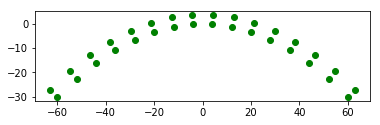

In [80]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);

Los elementos son exactamente los mismos que en el caso anterior.

In [81]:
els1 = genelem([[1,1,1],[1,1,nx]],[0,1],2*nx,x,fc(1e6))

In [82]:
els2 = genelem([[1,1,1]],[0,nx+1],nx+1,x,fc(1e6))

In [83]:
els3 = genelem([[1,1,1]],[0,nx+2],nx,x,fc(1e6))
els4 = genelem([[1,1,1]],[1,nx+1],nx,x,fc(1e6))

In [84]:
elementos = els1+els2+els3+els4

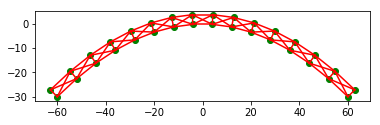

In [85]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);
f_dibelems(x,elementos);

In [86]:
cc = [[0,0],[0,1],[nx,1]]
fuerzas = genfuerzas([[1,0,1]],[nx+1,1],nx+1,x,fc(-10))

In [87]:
u=f_solve(x,elementos,fuerzas,cc)

Dibujamos los nodos sin deformar y los elementos según la deformada amplificada $10$ veces.

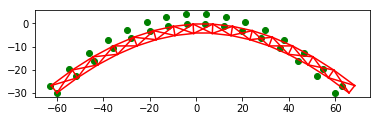

In [88]:
ax = plt.gca()
ax.set_aspect('equal')
f_dibnodos(x);
f_dibelems(x+u*10,elementos);

Aparte de los movimientos y de los axiles que ya hemos visto como se obtienen también podemos obtener las reacciones, que serán las fuerzas asociadas a las restricciones. En este caso, por ejemplo,las reacciones verticales están asociadas a los nodos `u[0]` y `u[nx]`.   
Como el apoyo derecho es un carrito y no hay fuerzas horizontales las únicas reacciones son las verticales que se pueden obtener multiplicando los movimientos de los nodos coaccionados por la constante de penalización $kpen$  
Las fuerzas aplicadas son unas fuerzas concentradas en los nodos superiores de valor $-10$ que hacen un total de $-160$.

In [89]:
u[0]

array([ 5.85482703e-32, -8.00000000e-19])

In [90]:
u[nx]

array([ 5.93152636e-01, -8.00000000e-19])

In [91]:
u[0][1]*kpen

-79.99999999996999

In [92]:
u[nx][1]*kpen

-79.99999999996753

# Ejercicio propuesto
Se propone resolver la siguiente cercha:
![esquema](ejercicio_propuesto1.png)

Con los siguientes valores:

|  l    |    EA     |     V  |
| ----  |   -----   |   ---- |
|  10   |   1000    |   10   |

Y obtener el movimiento horizontal del apoyo derecho.


***
Se desarrollará la solución en función de los parámetros de la misma, `l,EA,V`, de modo que sea fácil cambiar los valores de los mismos.

Primeramente se definen las coordenadas de los nodos.

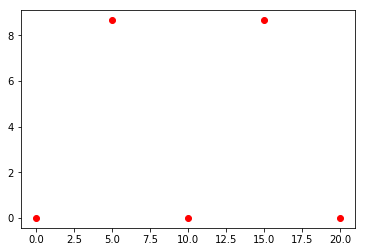

In [93]:
l = 10 
EA = 1000
V = 10
x = np.array([[0,0],[l,0],[2*l,0],[l/2.,l*math.sqrt(3)/2],[1.5*l,l*math.sqrt(3)/2]])
f_dibnodos(x,'or')

Y a continuación los elementos.

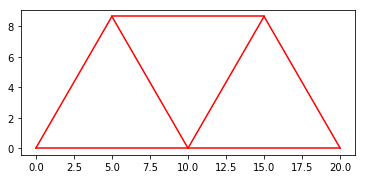

In [94]:
elementos = [[0,1,EA],[1,2,EA],[0,3,EA],[1,3,EA],[3,4,EA],[1,4,EA],[2,4,EA]]
ax = plt.gca()
ax.set_aspect('equal')
f_dibelems(x,elementos)

In [95]:
fuerzas = [[1,1,-V]]

In [96]:
cc = [[0,0],[0,1],[2,1]]

In [97]:
d =f_solve(x,elementos,fuerzas,cc)

In [98]:
print(d)

[[ 1.20370622e-35 -5.00000000e-20]
 [ 2.88675135e-02 -1.83333333e-01]
 [ 5.77350269e-02 -5.00000000e-20]
 [ 5.77350269e-02 -1.00000000e-01]
 [ 2.16840434e-17 -1.00000000e-01]]


Se pide el movimiento del nodo del apoyo derecho.

In [99]:
d[2][0]

0.0577350269189626

que si comparamos con la solución.

In [100]:
(V*l)/(math.sqrt(3)*EA)

0.05773502691896258

vemos que coincide.  
Representamos el modelo con un factor de escala de $10$

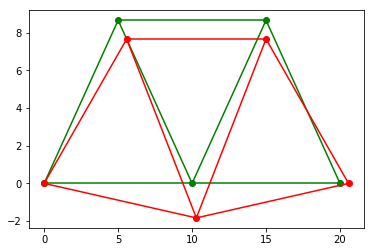

In [101]:
f_dibnodos(x)
f_dibelems(x,elementos,'g')
f_dibnodos(x+10*d,'or')
f_dibelems(x+10*d,elementos)

plt.show()

A continuación convertiremos el problema a una función.
Obtención del movimiento del apoyo derecho en función de `l,V y EA` y comparación con la solución analítica.

In [102]:
f_x = lambda l: np.array([[0,0],[l,0],[2*l,0],[l/2.,l*math.sqrt(3)/2],[1.5*l,l*math.sqrt(3)/2]])

In [103]:
f_elementos = lambda EA: [[0,1,EA],[1,2,EA],[0,3,EA],[1,3,EA],[3,4,EA],[1,4,EA],[2,4,EA]]

In [104]:
f_fuerzas = lambda V:  [[1,1,-V]]

In [105]:
f_fin = lambda l,V,EA: f_solve(f_x(l),f_elementos(EA),f_fuerzas(V),cc)

In [106]:
f_fin(10,20,1000)[2,0]

0.1154700538379252

Y representaremos la solución obtenida para distintos valores de $EA$  comparada con la solución analítica.

In [107]:
xx = np.linspace(500,5000,20)
yy = list(map(lambda u: f_fin(10,20,u)[2,0],xx))
yy2 = list(map(lambda u: 20*10/(math.sqrt(3)*u),xx))

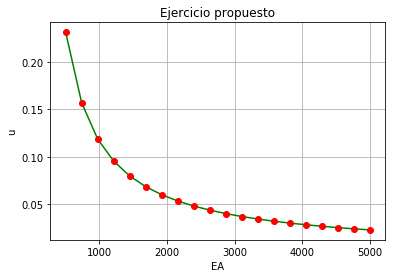

In [108]:
plt.xlabel('EA')
plt.ylabel('u')
plt.title('Ejercicio propuesto')
plt.grid(True)
plt.plot(xx,yy,'g',xx,yy2,'or')